In [2]:
import psycopg2, psycopg2.extras, psycopg2.pool
from multiprocessing import Pool, Manager
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
%matplotlib inline

# User Focus Analysis

_User Focus_ is the percentage of a user's total edits that occur on any given tile. Though a user may have a significant number of edits across hundreds of thousands of tiles, we tend to find that they have a single tile or set of tiles that take up a significant portion of their focus.

In [3]:
years = 12
connections = {}
connections2 = {}
def reset():
    print("Building Connections...")
    for year in [2005+i for i in range(years)]:
        print(year, end=" . ")
        d = "dbname=world-"+str(year)+" user=anderstj host=127.0.0.1"
        conn1 = psycopg2.pool.PersistentConnectionPool(1, 5, dsn=d)
        conn2 = psycopg2.pool.PersistentConnectionPool(1, 5, dsn=d)
        connections[year]  = conn1.getconn().cursor( cursor_factory = psycopg2.extras.DictCursor)
        connections2[year] = conn2.getconn().cursor( cursor_factory = psycopg2.extras.DictCursor)
    print("done")
reset()

Building Connections...
2005 . 2006 . 2007 . 2008 . 2009 . 2010 . 2011 . 2012 . 2013 . 2014 . 2015 . 2016 . done


In [4]:
class User():
    def __init__(self, uid, e, km, b, a, days):
        self.uid = uid,
        self.km  = km;
        self.b   = b;
        self.e   = e;
        self.a   = a;
        self.days  = days;
        self.tiles = {}
        
    def add_tile(self, q, e, km, b, a, days):
        self.tiles[q] = [e,km,b,a,days]
    
    def coalesce(self, other_self):
        self.km += other_self.km
        self.b  += other_self.b
        self.e  += other_self.e
        self.a  += other_self.a
        self.days += other_self.days
        
        for q, d in other_self.tiles.items():
            if q in self.tiles:
                self.tiles[q][0] += d[0]
                self.tiles[q][1] += d[1]
                self.tiles[q][2] += d[2]
                self.tiles[q][3] += d[3]
                self.tiles[q][4] += d[4]
            else:
                self.tiles[q] = d
                
    def get_edit_distribution(self):
        return [t[0]/self.e for t in self.tiles.values()]
    
    def get_days_distribution(self):
        return [t[4]/self.days for t in self.tiles.values()]
    
    def get_km_distribution(self):
        return [t[1]/self.km for t in self.tiles.values()]

    def get_building_distribution(self):
        return [t[2]/self.b for t in self.tiles.values()]
    
    def get_amenity_distribution(self):
        return [t[3]/self.a for t in self.tiles.values()]

def calculate_user_focus_per_year(year):
    connections[year].execute("select uid, edits, road_km, buildings, amenities, array_length(active_days,1) from user_stats")    
    
    users = {}
    
    for user_row in connections[year]:

        #Create the User Object
        this_user = User(user_row[0], user_row[1], user_row[2], user_row[3], user_row[4], user_row[5])

        #PerTileInfo
        connections2[year].execute("select \
            quadkey, edits, road_km, buildings, amenities, array_length(active_days,1) \
            from per_tile where uid  = %s",(user_row['uid'],))
        for per_tile_edits in connections2[year]:
            this_user.add_tile(
                per_tile_edits[0],
                per_tile_edits[1],
                per_tile_edits[2],
                per_tile_edits[3],
                per_tile_edits[4],
                per_tile_edits[5]
            )
        users[user_row[0]] = this_user

    return users

In [4]:
#Parallel Runtime
reset()
years = 12
query_years = [i+2005 for i in range(years)]
pool = Pool(processes=5)
par = pool.map_async(calculate_user_focus_per_year, query_years)
pool.close()
pool.join()

Building Connections...
2005 . 2006 . 2007 . 2008 . 2009 . 2010 . 2011 . 2012 . 2013 . 2014 . 2015 . 2016 . done


In [5]:
totals = {}
for year_data in par.get():
    for uid, user in year_data.items():
        if uid in totals:
            totals[uid].coalesce(user)
        else:
            totals[uid] = user

In [67]:
len(totals)

553728

# Distribution of Days / Editor (& Edits / Editor)

In [33]:
days_per_user = [user.days for user in totals.values()]
edits_per_user = [user.e for user in totals.values()]
edits_from_users_with_more_than_7_days = [user.e for user in totals.values() if user.days > 7]

In [59]:
print("Total Edits: ",sum(edits_per_user))
print("Total Edits from Users with more than 7 days: ",sum(edits_from_users_with_more_than_7_days))
print("Percent: ", sum(edits_from_users_with_more_than_7_days)/sum(edits_per_user))
days_per_user_numpy = np.array(days_per_user)
print("Percent of Users with just 1 editing day", sum(days_per_user_numpy == 1)/len(totals))
print("Percent of Users with >7 days",len(edits_from_users_with_more_than_7_days)/len(totals))

Total Edits:  970819378
Total Edits from Users with more than 7 days:  948758735
Percent:  0.9772762642568513
Percent of Users with just 1 editing day 0.568042432386
Percent of Users with >7 days 0.13362878525196487


97.7% of the edits are form users who are active for more than 7 days, see the distribution below.
Over half of the contributors have only contributed one day.

Choosing 7 days as an experience threshold retains 97.7% of the edits and 13% of the active users. Empirical analysis, as shown below gives an edits/user distribution that is roughly lognormal.

Percent of Users with just 1 editing day 0.568042432386
Percent of Users with >7 days 0.13362878525196487


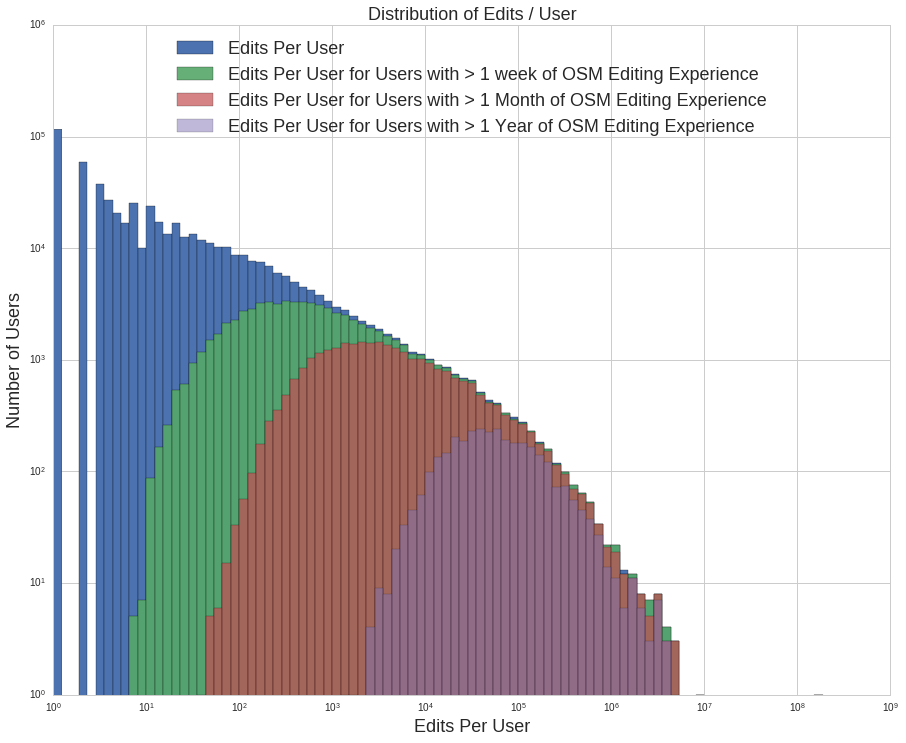

In [54]:
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,12), facecolor='w', edgecolor='k')

ax.hist(edits_per_user,bins=np.logspace(0,9,100), label="Edits Per User")
ax.hist(edits_from_users_with_more_than_7_days, bins=np.logspace(0,9,100), alpha=0.9, label="Edits Per User for Users with > 1 week of OSM Editing Experience")
ax.hist([user.e for user in totals.values() if user.days > 31], bins=np.logspace(0,9,100), alpha=0.7, label="Edits Per User for Users with > 1 Month of OSM Editing Experience")
ax.hist([user.e for user in totals.values() if user.days > 368], bins=np.logspace(0,9,100), alpha=0.5, label="Edits Per User for Users with > 1 Year of OSM Editing Experience")
ax.set_yscale('log')
ax.set_xscale('log')

plt.title("Distribution of Edits / User",fontsize=18)
plt.ylabel("Number of Users", fontsize=18)
plt.xlabel("Edits Per User", fontsize=18)
plt.legend(fontsize=18, loc="upper center")
None

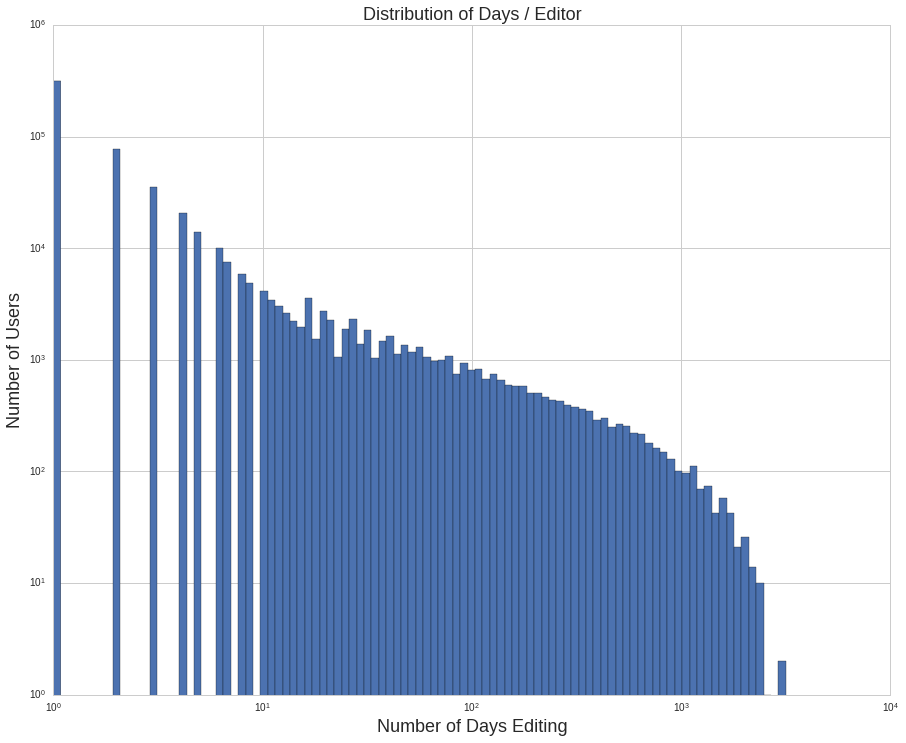

In [21]:
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,12), facecolor='w', edgecolor='k')

ax.hist(days_per_user,bins=np.logspace(0,3.5,100))

ax.set_yscale('log')
ax.set_xscale('log')

plt.title("Distribution of Days / Editor",fontsize=18)
plt.ylabel("Number of Users", fontsize=18)
plt.xlabel("Number of Days Editing", fontsize=18)
None

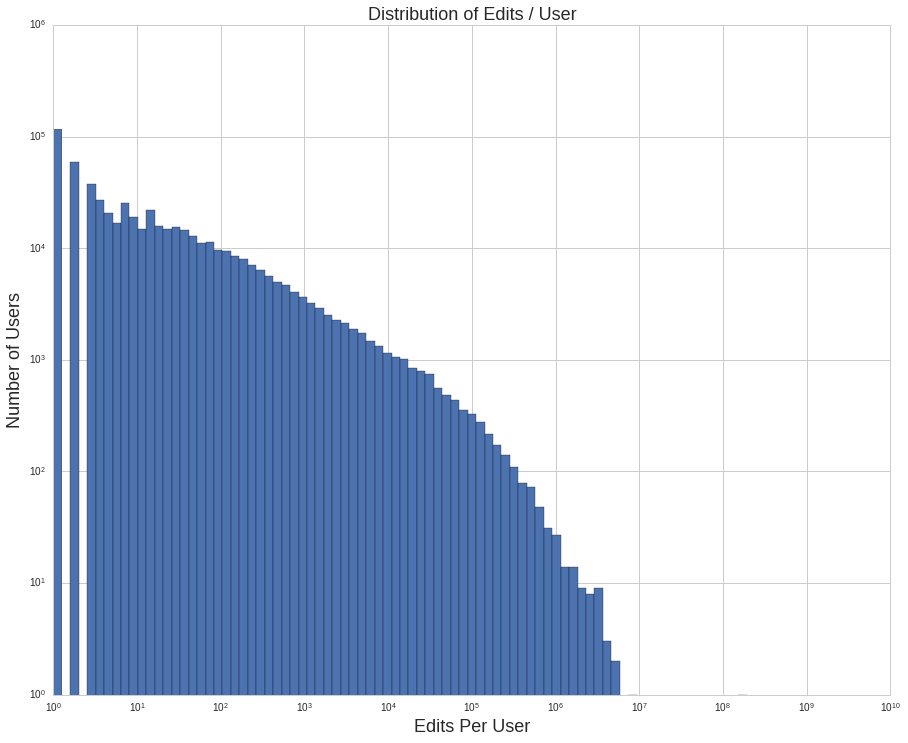

In [26]:
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,12), facecolor='w', edgecolor='k')

ax.hist(edits_per_user,bins=np.logspace(0,10,100))

ax.set_yscale('log')
ax.set_xscale('log')

plt.title("Distribution of Edits / User",fontsize=18)
plt.ylabel("Number of Users", fontsize=18)
plt.xlabel("Edits Per User", fontsize=18)
None

In [36]:
max_edits = [max([t[0]/user.e for t in user.tiles.values()]) for user in totals.values()]

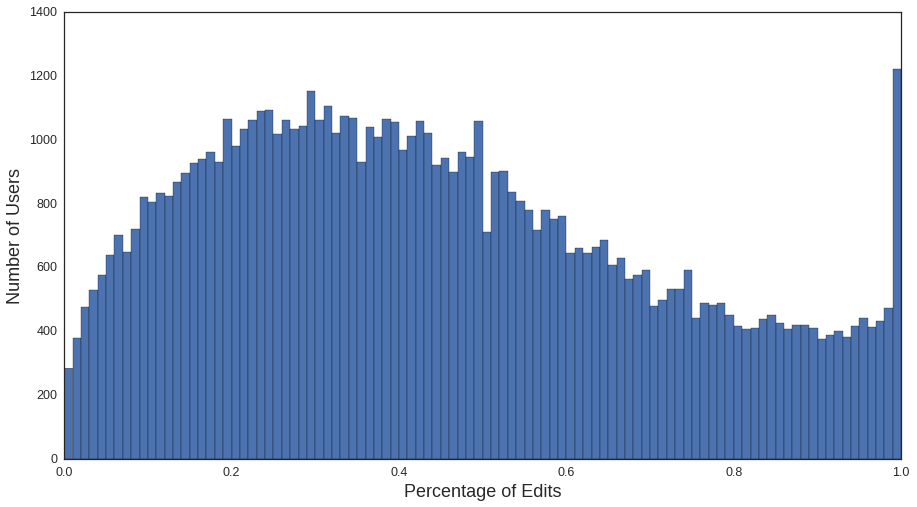

In [66]:
#Plot of Tiles with Highest Percentages
sns.set(font_scale=1.25)
plt.style.use('seaborn-white')
plt.figure().set_size_inches(15,8)
threshold = 7
X = [max([t[0]/user.e for t in user.tiles.values()]) for user in totals.values() if (user.days > threshold)]
# plt.title("Maximum Percentage of of a user's edits on a tile \n (For users with more than %s active days): [%s Users]"%(threshold, len(X)),fontsize=18)
plt.ylabel("Number of Users", fontsize=18)
plt.xlabel("Percentage of Edits", fontsize=18)
plt.hist(X,bins=100)
None

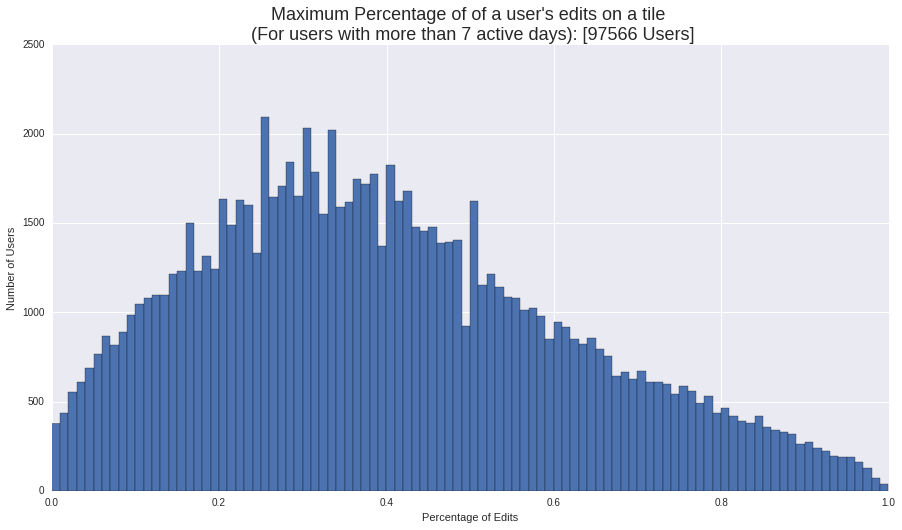

In [53]:
#Plot of Tiles with Highest Percentages
plt.figure().set_size_inches(15,8)
threshold = 7
X = [max([t[0]/user.e for t in user.tiles.values()]) for user in totals.values() if len(user.tiles)>5]
plt.title("Maximum Percentage of of a user's edits on a tile \n (For users with edits on more than %s tiles): [%s Users]"%(threshold, len(X)),fontsize=18)
plt.ylabel("Number of Users")
plt.xlabel("Percentage of Edits")
plt.hist(X,bins=100)
None

In [400]:
tiles_per_user = [len(user.tiles) for user in totals.values()]
print(len(tiles_per_user))
x = Counter(tiles_per_user)
to_plot = sorted(x.items(), key = lambda x: x[0], reverse=True)

553728


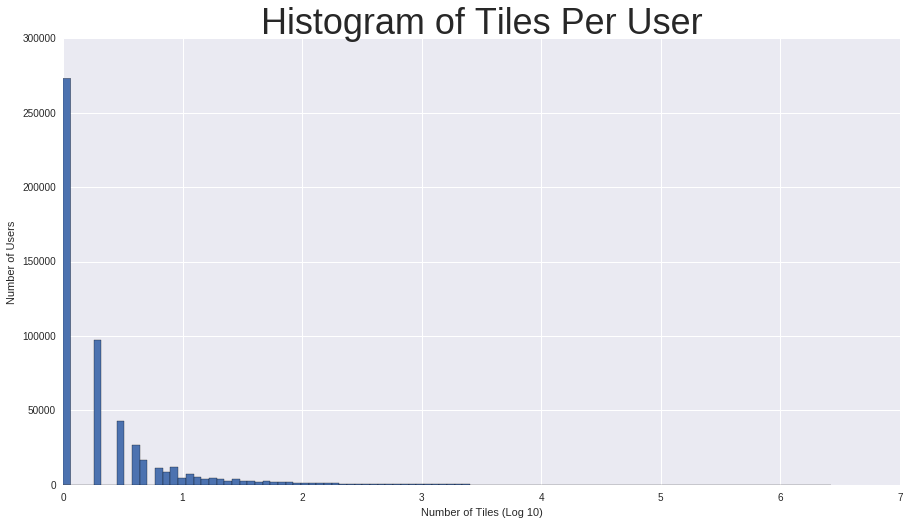

In [401]:
plt.figure().set_size_inches(15,8)
plt.hist(np.log10(tiles_per_user), bins=100)
plt.title("Histogram of Tiles Per User", fontsize=36)
plt.xlabel("Number of Tiles (Log 10)")
plt.ylabel("Number of Users")

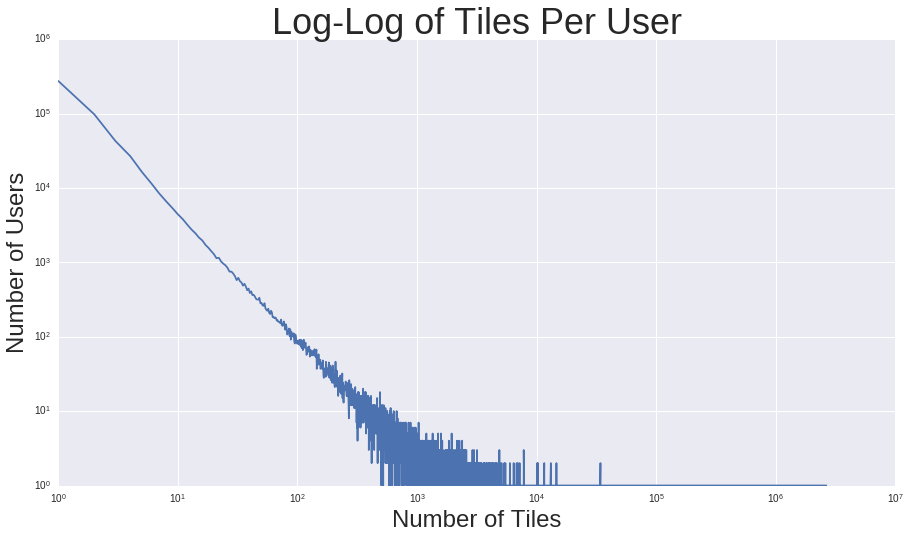

In [403]:
plt.figure().set_size_inches(15,8)
plt.title("Log-Log of Tiles Per User", fontsize=36)
plt.xlabel("Number of Tiles", fontsize=24)
plt.ylabel("Number of Users", fontsize=24)
plt.loglog([_[0] for _ in to_plot], [_[1] for _ in to_plot])

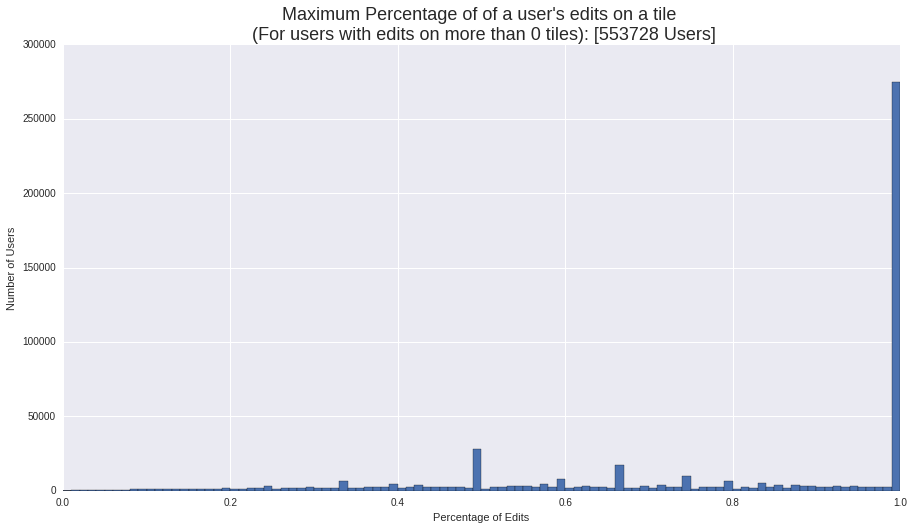

In [406]:
plt.figure().set_size_inches(15,8)
threshold = 0
x = [max(user.get_edit_distribution()) for user in list(totals.values()) if len(user.tiles) > threshold]
plt.title("Maximum Percentage of of a user's edits on a tile \n (For users with edits on more than %s tiles): [%s Users]"%(threshold, len(x)),fontsize=18)
plt.ylabel("Number of Users")
plt.xlabel("Percentage of Edits")
plt.hist(x,bins=100)
None

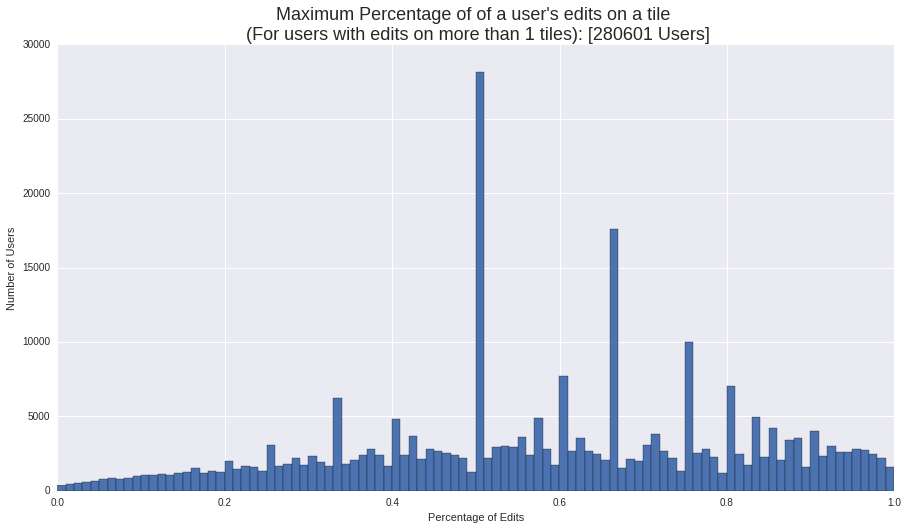

In [407]:
plt.figure().set_size_inches(15,8)
threshold = 1
x = [max(user.get_edit_distribution()) for user in list(totals.values()) if len(user.tiles) > threshold]
plt.title("Maximum Percentage of of a user's edits on a tile \n (For users with edits on more than %s tiles): [%s Users]"%(threshold, len(x)),fontsize=18)
plt.ylabel("Number of Users")
plt.xlabel("Percentage of Edits")
plt.hist(x,bins=100)
None

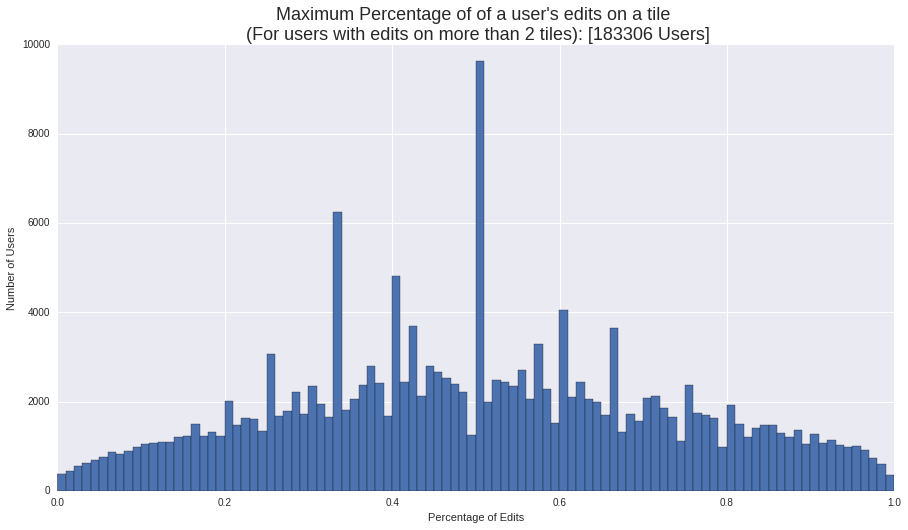

In [404]:
plt.figure().set_size_inches(15,8)
threshold = 2
x = [max(user.get_edit_distribution()) for user in list(totals.values()) if len(user.tiles) > threshold]
plt.title("Maximum Percentage of of a user's edits on a tile \n (For users with edits on more than %s tiles): [%s Users]"%(threshold, len(x)),fontsize=18)
plt.ylabel("Number of Users")
plt.xlabel("Percentage of Edits")
plt.hist(x,bins=100)
None

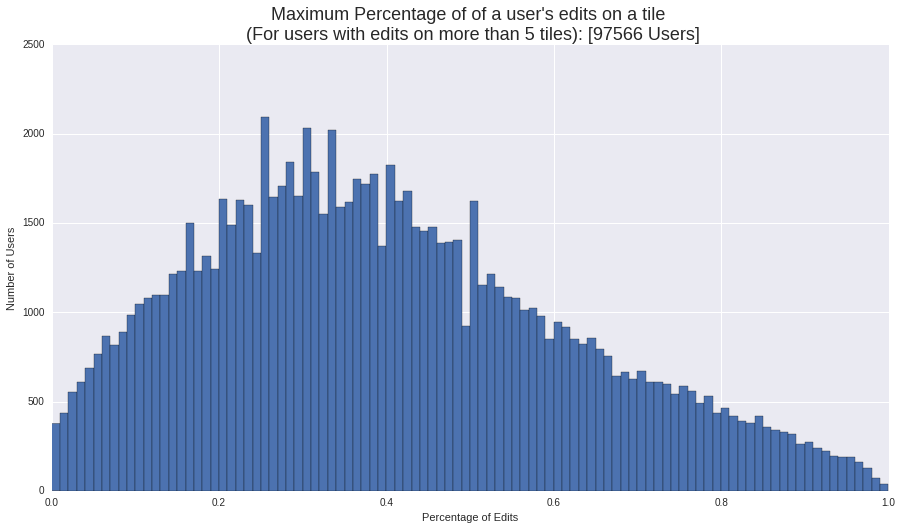

In [405]:
plt.figure().set_size_inches(15,8)
threshold = 5
x = [max(user.get_edit_distribution()) for user in list(totals.values()) if len(user.tiles) > threshold]
plt.title("Maximum Percentage of of a user's edits on a tile \n (For users with edits on more than %s tiles): [%s Users]"%(threshold, len(x)),fontsize=18)
plt.ylabel("Number of Users")
plt.xlabel("Percentage of Edits")
plt.hist(x,bins=100)
None

In [445]:
np.mean(x)

0.5775350847202827

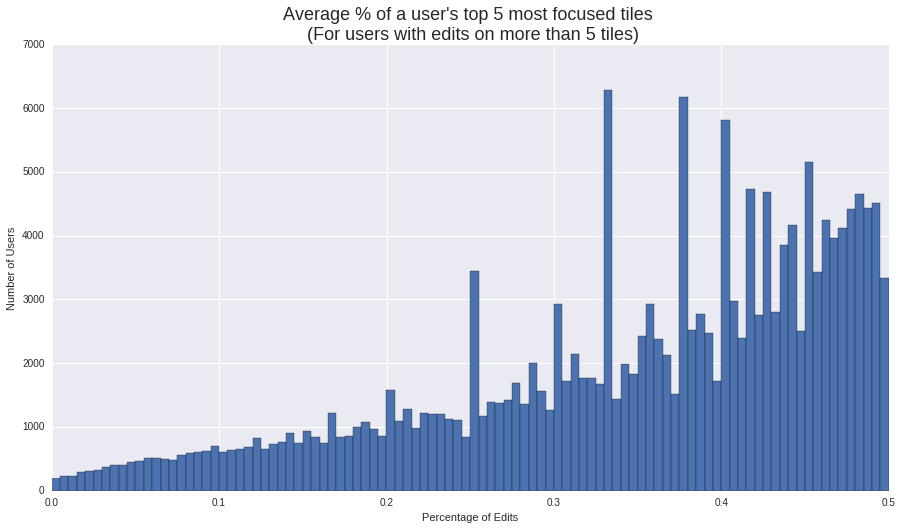

In [387]:
plt.figure().set_size_inches(15,8)
plt.title("Average % of a user's top 5 most focused tiles \n (For users with edits on more than 5 tiles)",fontsize=18)
plt.ylabel("Number of Users")
plt.xlabel("Percentage of Edits")
plt.hist(y,bins=100)
None

## How about some more of that User Experience?

In [ ]:
kms = [];
bs  = [];

for uid, user in totals.items():
    u_km = 1
    u_bs = 1
    for quadkey, tile in user.tiles.items():
        u_km += tile[1]
        u_bs += tile[2]
    kms.append(u_km)
    bs.append(u_bs)

In [84]:
H, xedges, yedges = np.histogram2d(kms, bs, bins=np.logspace(base=10,start=0,stop=7,num=40))
H = np.rot90(H)
H = np.flipud(H)

In [85]:
print(max(kms), max(bs))

10353198.714358613 8842174


In [107]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-white')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,12), facecolor='w', edgecolor='k')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim([1,np.power(10,7)])
ax.set_xlim([1,np.power(10,7)])
ax.set_title("Buildings vs. Roads: Global")
ax.set_xlabel('kilometers of roads edited', fontsize=16)
ax.set_ylabel('buildings edited', fontsize=16)

p = ax.pcolormesh(xedges,yedges,H,norm = matplotlib.colors.PowerNorm(gamma=0.3),
                      cmap='RdBu_r', vmin=0, vmax=190000)
plt.colorbar(p)

In [90]:
H[0][0]

182678.0

# Now that we've done it for the globe, how about our 4 tiles?

In [75]:
pap     = '032211203001' 
romania = '120322103020'
dc      = '032010032232'
aus     = '311220303000'
study_data = [
    {'name':'Port Au Prince, Haiti', 'quad':pap,    'users':None},
    {'name':'Bucharest, Romania',    'quad':romania,'users':None},
    {'name':'Washington DC',         'quad':dc,     'users':None},
    {'name':'Adelaide, Australia',   'quad':aus,    'users':None}
]

In [97]:
key = 3
quadkey = study_data[key]['quad']

In [98]:
def calculate_user_focus_for_specific_tile(year):
    #Do the same thing as before, just be sure to save off this particular tile in the user objects
    connections[year].execute("select distinct(uid) from per_tile where quadkey = %s",(quadkey,))
    uids = [x[0] for x in connections[year].fetchall()]
    
    connections[year].execute("select uid, edits, road_km, buildings, amenities, array_length(active_days,1) from user_stats where uid = ANY(%s)",(uids,))   
    
    users = {}
    
    for user_row in connections[year]:

        #Create the User Object
        this_user = User(user_row[0], user_row[1], user_row[2], user_row[3], user_row[4], user_row[5])

        #PerTileInfo
        connections2[year].execute("select \
            quadkey, edits, road_km, buildings, amenities, array_length(active_days,1) \
            from per_tile where uid  = %s",(user_row['uid'],))
        for per_tile_edits in connections2[year]:
            this_user.add_tile(
                per_tile_edits[0],
                per_tile_edits[1],
                per_tile_edits[2],
                per_tile_edits[3],
                per_tile_edits[4],
                per_tile_edits[5]
            )
        users[user_row[0]] = this_user

    return users

In [99]:
#Parallel Runtime
reset()
years = 12
query_years = [i+2005 for i in range(years)]
pool = Pool(processes=5)
par = pool.map_async(calculate_user_focus_for_specific_tile, query_years)
pool.close()
pool.join()

Building Connections...
2005 . 2006 . 2007 . 2008 . 2009 . 2010 . 2011 . 2012 . 2013 . 2014 . 2015 . 2016 . done


In [100]:
study_data[key]['users'] = {}
for year_data in par.get():
    for uid, user in year_data.items():
        if uid in study_data[key]['users']:
            study_data[key]['users'][uid].coalesce(user)
        else:
            study_data[key]['users'][uid] = user

In [101]:
len(study_data[key]['users'])

250

In [102]:
#Save for Safety?
# import pickle
# pickle.dump(study_data, open('/home/anderstj/data/all_users_v2.pickle','wb'))

# Processing Our Four Tiles Of Interest
For safety, the data is `pickled` to the directory `/home/anderstj/data/[tile]_focus_data.pickle`

(This code is meant to be entirely reproduceable from loading the pickle file)

In [103]:
#Be sure to run the Declaration Code above for the classes like User and PerTileUser
# import pickle
# study_data     = pickle.load(open('/home/anderstj/data/all_users_v2.pickle','rb'))

Port Au Prince, Haiti - Users above 0.58: 59
Bucharest, Romania - Users above 0.58: 213
Washington DC - Users above 0.58: 91
Adelaide, Australia - Users above 0.58: 38


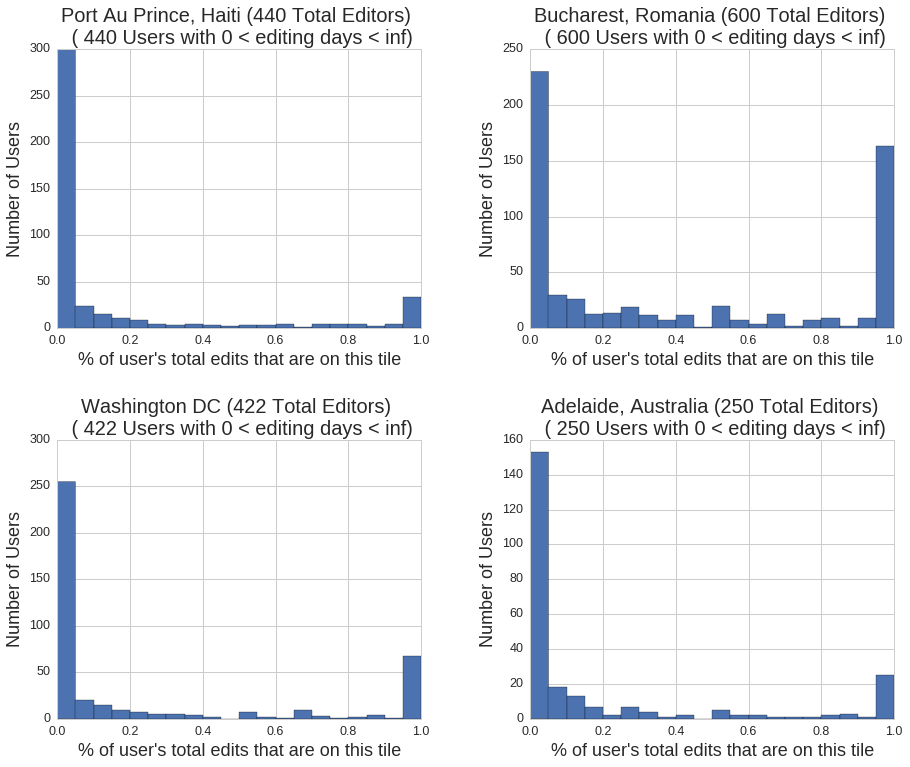

In [146]:
# Plot 4 Histograms
upper_threshold = np.Inf
lower_threshold = 0

percentage_threshold = 0.58

sns.set(font_scale=1.25)
sns.despine()
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,12), facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=0.3, hspace=0.4)

for idx, ax in enumerate(axs.ravel()):
    to_plot = []
    for uid, user in study_data[idx]['users'].items():
        if user.days > lower_threshold and user.days < upper_threshold:
            to_plot.append( user.tiles[study_data[idx]['quad']][0] / user.e )

    ax.hist(to_plot, bins=np.arange(0,1.01,0.05))
    ax.set_title("%s (%s Total Editors) \n ( %s Users with %s < editing days < %s)"%(study_data[idx]['name'], len(study_data[idx]['users']), len(to_plot), lower_threshold, upper_threshold), fontsize=20)
    ax.set_ylabel("Number of Users", fontsize=18)
    ax.set_xlabel("% of user's total edits that are on this tile", fontsize=18)
    ax.set_xlim([0,1])
    
    percentages = np.array(to_plot)
    print("%s - Users above %s: %s"%(study_data[idx]['name'], percentage_threshold, sum(percentages > percentage_threshold)))

Port Au Prince, Haiti - Users above 0.58: 6
Bucharest, Romania - Users above 0.58: 7
Washington DC - Users above 0.58: 5
Adelaide, Australia - Users above 0.58: 1


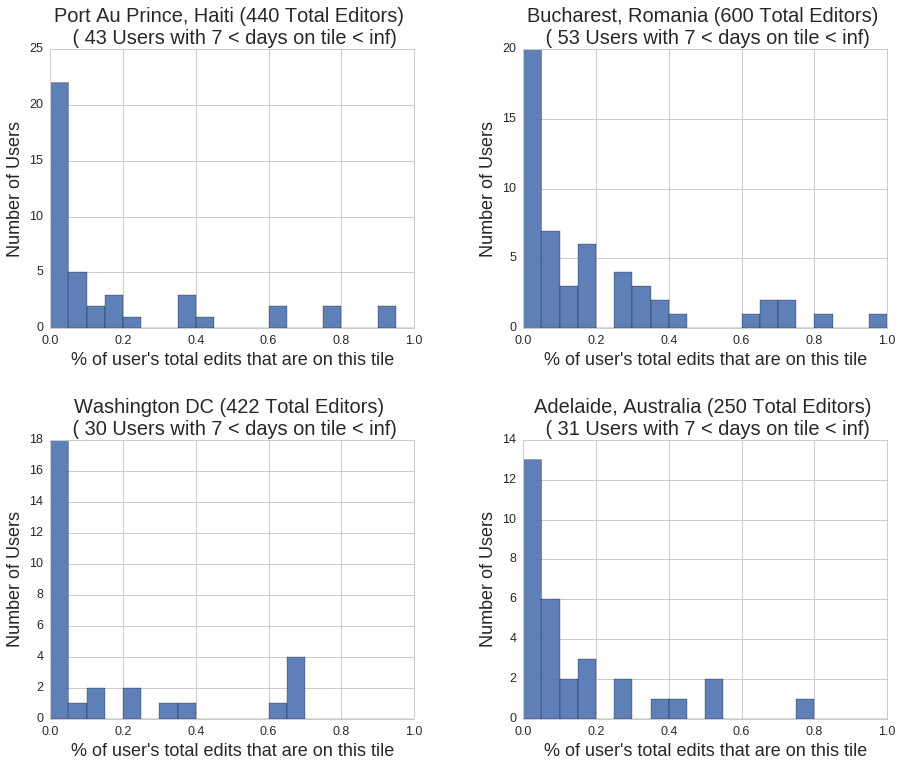

In [147]:
# Plot 4 Histograms
upper_threshold = np.Inf
lower_threshold = 7

percentage_threshold = 0.58

sns.set(font_scale=1.25)
sns.despine()
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,12), facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=0.3, hspace=0.4)

for idx, ax in enumerate(axs.ravel()):
    to_plot = []
    all_users = []
    for uid, user in study_data[idx]['users'].items():
        all_users.append( user.tiles[study_data[idx]['quad']][0] / user.e )
        
        if user.tiles[study_data[idx]['quad']][4] > lower_threshold and user.tiles[study_data[idx]['quad']][4] < upper_threshold:
            to_plot.append( user.tiles[study_data[idx]['quad']][0] / user.e )

#     all_bar  = ax.hist(all_users, bins=np.arange(0,1.01,0.05))
    plot_bar = ax.hist(to_plot,   bins=np.arange(0,1.01,0.05), alpha=0.9)
    ax.set_title("%s (%s Total Editors) \n ( %s Users with %s < days on tile < %s)"%(study_data[idx]['name'], len(study_data[idx]['users']), len(to_plot), lower_threshold, upper_threshold), fontsize=20)
    ax.set_ylabel("Number of Users", fontsize=18)
    ax.set_xlabel("% of user's total edits that are on this tile", fontsize=18)
    ax.set_xlim([0,1])
    
    percentages = np.array(to_plot)
    print("%s - Users above %s: %s"%(study_data[idx]['name'], percentage_threshold, sum(percentages > percentage_threshold)))

# plt.figlegend([all_bar, plot_bar],
#               ["All Users","Users with (Users with %s < buildings < %s)"%(lower_threshold, upper_threshold)],
#               loc="upper center")

Port Au Prince, Haiti - Users above 0.25: 14
Normalized (% of Matching Users):  14 0.0318181818182
Of ALL contributors:  80 0.18181818181818182
Bucharest, Romania - Users above 0.25: 25
Normalized (% of Matching Users):  25 0.0416666666667
Of ALL contributors:  279 0.465
Washington DC - Users above 0.25: 8
Normalized (% of Matching Users):  8 0.0189573459716
Of ALL contributors:  113 0.2677725118483412
Adelaide, Australia - Users above 0.25: 9
Normalized (% of Matching Users):  9 0.036
Of ALL contributors:  55 0.22


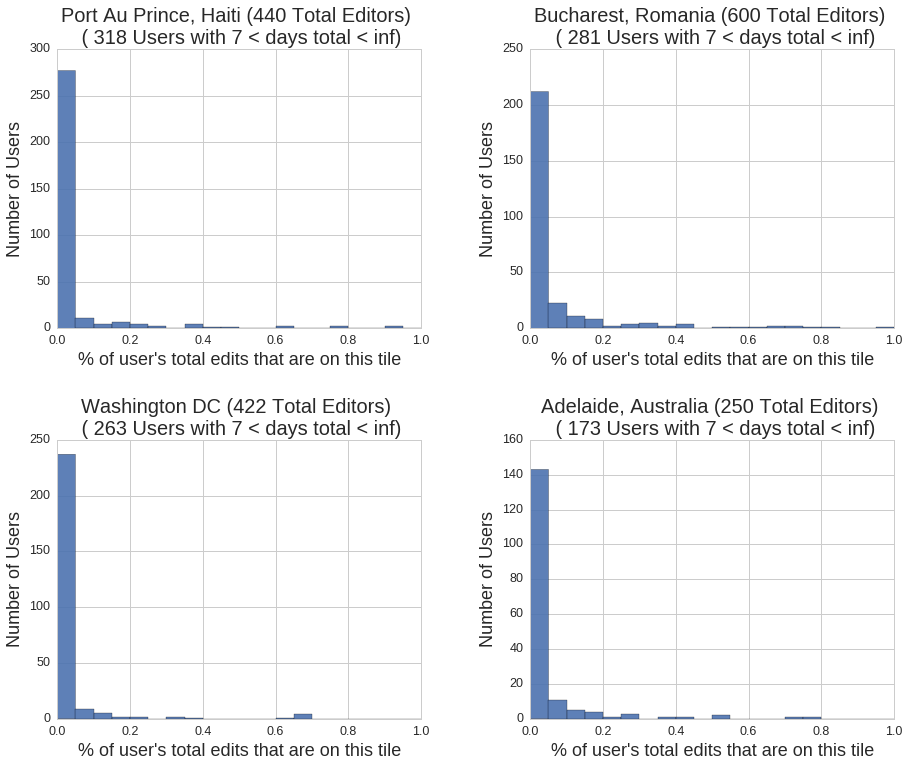

In [162]:
# Plot 4 Histograms
upper_threshold = np.Inf
lower_threshold = 7

percentage_threshold = 0.25


sns.set(font_scale=1.25)
sns.despine()
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,12), facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=0.3, hspace=0.4)

for idx, ax in enumerate(axs.ravel()):
    to_plot = []
    all_users = []
    count = 0;
    for uid, user in study_data[idx]['users'].items():
        all_users.append( user.tiles[study_data[idx]['quad']][0] / user.e )
        
        if (user.tiles[study_data[idx]['quad']][0] / user.e) > percentage_threshold:
            count+=1;
        
        if user.days > lower_threshold and user.days < upper_threshold:
            to_plot.append( user.tiles[study_data[idx]['quad']][0] / user.e )

#     all_bar  = ax.hist(all_users, bins=np.arange(0,1.01,0.05))
    plot_bar = ax.hist(to_plot,   bins=np.arange(0,1.01,0.05), alpha=0.9)
    ax.set_title("%s (%s Total Editors) \n ( %s Users with %s < days total < %s)"%(study_data[idx]['name'], len(study_data[idx]['users']), len(to_plot), lower_threshold, upper_threshold), fontsize=20)
    ax.set_ylabel("Number of Users", fontsize=18)
    ax.set_xlabel("% of user's total edits that are on this tile", fontsize=18)
    ax.set_xlim([0,1])
    
    
    
    percentages = np.array(to_plot)
    print("%s - Users above %s: %s"%(study_data[idx]['name'], percentage_threshold, sum(percentages > percentage_threshold)))
    print("Normalized (% of Matching Users): ", sum(percentages > percentage_threshold), sum(percentages > percentage_threshold)/len(study_data[idx]['users']))
    print("Of ALL contributors: ", count, count/len(study_data[idx]['users']))

# plt.figlegend([all_bar, plot_bar],
#               ["All Users","Users with (Users with %s < buildings < %s)"%(lower_threshold, upper_threshold)],
#               loc="upper center")

Port Au Prince - Users above 0.58: 2
Romania - Users above 0.58: 8
DC - Users above 0.58: 4
Australia - Users above 0.58: 3


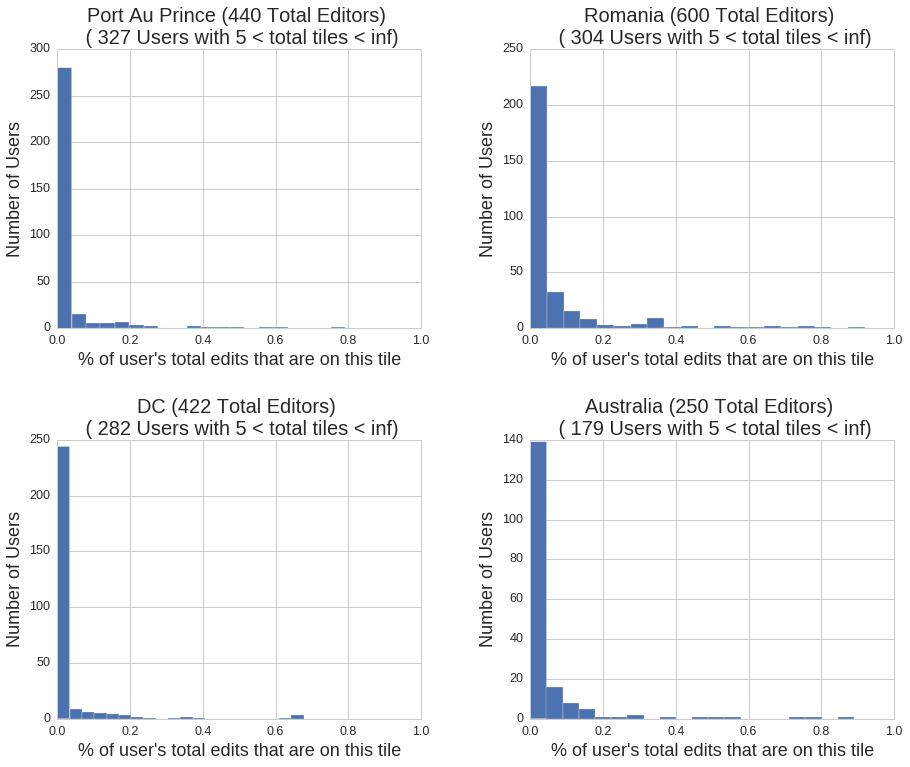

In [109]:
# Plot 4 Histograms
upper_threshold = np.Inf
lower_threshold = 5

percentage_threshold = 0.58

sns.set(font_scale=1.25)
sns.despine()
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,12), facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=0.3, hspace=0.4)
for idx, ax in enumerate(axs.ravel()):
    to_plot = []
    for uid, user in data[idx].items():
        if len(user.tiles) > lower_threshold and len(user.tiles) < upper_threshold:
            to_plot.append( sum(user.tiles[quads[idx]].e)/user.e )

    ax.hist(to_plot, bins=20)
    ax.set_title("%s (%s Total Editors) \n ( %s Users with %s < total tiles < %s)"%(names[idx], len(data[idx]), len(to_plot), lower_threshold, upper_threshold), fontsize=20)
    ax.set_ylabel("Number of Users", fontsize=18)
    ax.set_xlabel("% of user's total edits that are on this tile", fontsize=18)
    ax.set_xlim([0,1])
    
    percentages = np.array(to_plot)
    print("%s - Users above %s: %s"%(names[idx], percentage_threshold, sum(percentages > percentage_threshold)))

Port Au Prince - Users above 0.58: 29
Romania - Users above 0.58: 86
DC - Users above 0.58: 40
Australia - Users above 0.58: 21


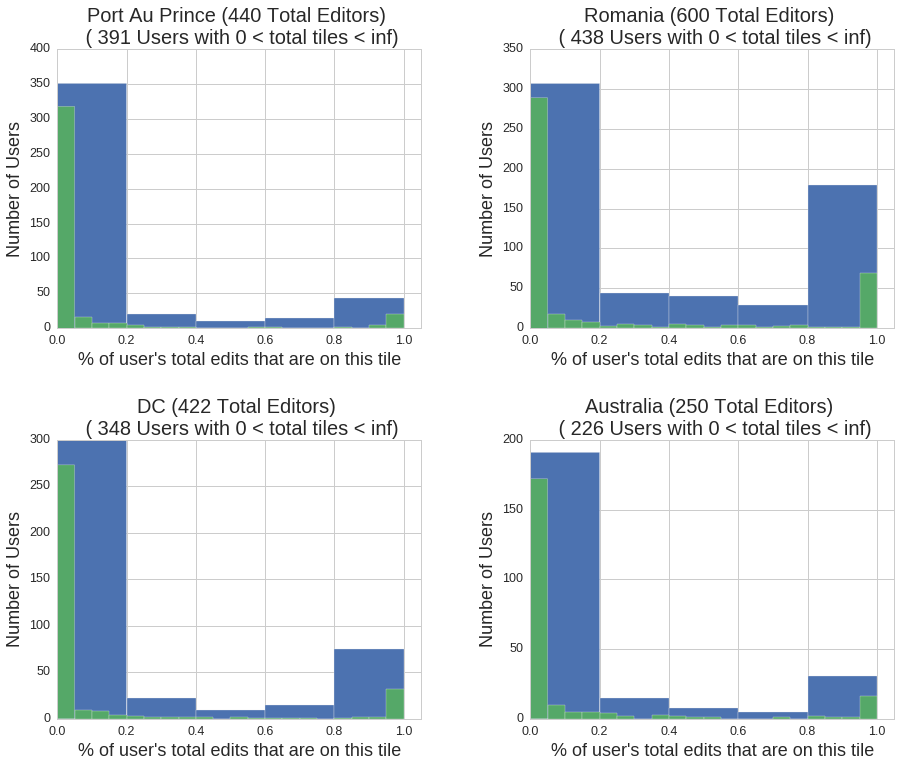

In [143]:
# Plot 4 Histograms
upper_threshold = np.Inf
lower_threshold = 0

percentage_threshold = 0.58

sns.set(font_scale=1.25)
sns.despine()
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,12), facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=0.3, hspace=0.4)
for idx, ax in enumerate(axs.ravel()):
    to_plot = []
    edits   = []
    for uid, user in data[idx].items():
        if len(user.tiles) > lower_threshold and len(user.tiles) < upper_threshold:
            if user.km > 0:
                to_plot.append( sum(user.tiles[quads[idx]].km)/user.km )
            edits.append( sum(user.tiles[quads[idx]].e)/user.e )
    ax.hist(edits, bins=5)
    ax.hist(to_plot, bins=20)
    ax.set_title("%s (%s Total Editors) \n ( %s Users with %s < total tiles < %s)"%(names[idx], len(data[idx]), len(to_plot), lower_threshold, upper_threshold), fontsize=20)
    ax.set_ylabel("Number of Users", fontsize=18)
    ax.set_xlabel("% of user's total edits that are on this tile", fontsize=18)
    ax.set_xlim([0,1.05])
    
    percentages = np.array(to_plot)
    print("%s - Users above %s: %s"%(names[idx], percentage_threshold, sum(percentages > percentage_threshold)))

## Follow Up Question, do there exist tiles that are not a user's sole focus?

In [ ]:
# Calculation Process:
# Same process, need to calculate user focus on a per_tile level, need to put all tiles into memory, then calculate
# User Focus.  Could do this with SQL Queries per year?

#Get (quadkey, # users) for users who have ALL of their edits on a single quad in a given year
"""select quadkey, count(per_tile.uid) from per_tile, user_stats WHERE (per_tile.edits::float/user_stats.edits::float) = 1.0 AND per_tile.uid = user_stats.uid group by per_tile.quadkey"""

#For fun, add this: AND user_stats.edits > 100

In [130]:
#To do some sort of distribution, consider this type of query (run 100 times)
def quadkeys_with_single_users(year):
    quadKeyCounts = []
    for threshold in np.arange(0,1,0.01):
        connections[year].execute("SELECT count(distinct(quadkey)) \
        FROM per_tile, user_stats \
        WHERE (per_tile.edits::float/user_stats.edits::float) > %s AND \
            per_tile.uid = user_stats.uid",(threshold,))
        quadKeyCounts.append(connections[year].fetchall()[0])
    return quadKeyCounts

In [ ]:
#Parallel Runtime
years = 12
reset()
query_years = [i+2005 for i in range(years)]
pool = Pool(processes=5)
par = pool.map_async(quadkeys_with_single_users, query_years)
pool.close()
pool.join()

Building Connections...
2005 . 2006 . 2007 . 2008 . 2009 . 2010 . 2011 . 2012 . 2013 . 2014 . 2015 . 2016 . done


In [133]:
annual_dist = par.get()

In [134]:
len(annual_dist)

12

In [135]:
annual_dist[0][:10]

[[695], [230], [163], [131], [108], [94], [83], [77], [70], [65]]

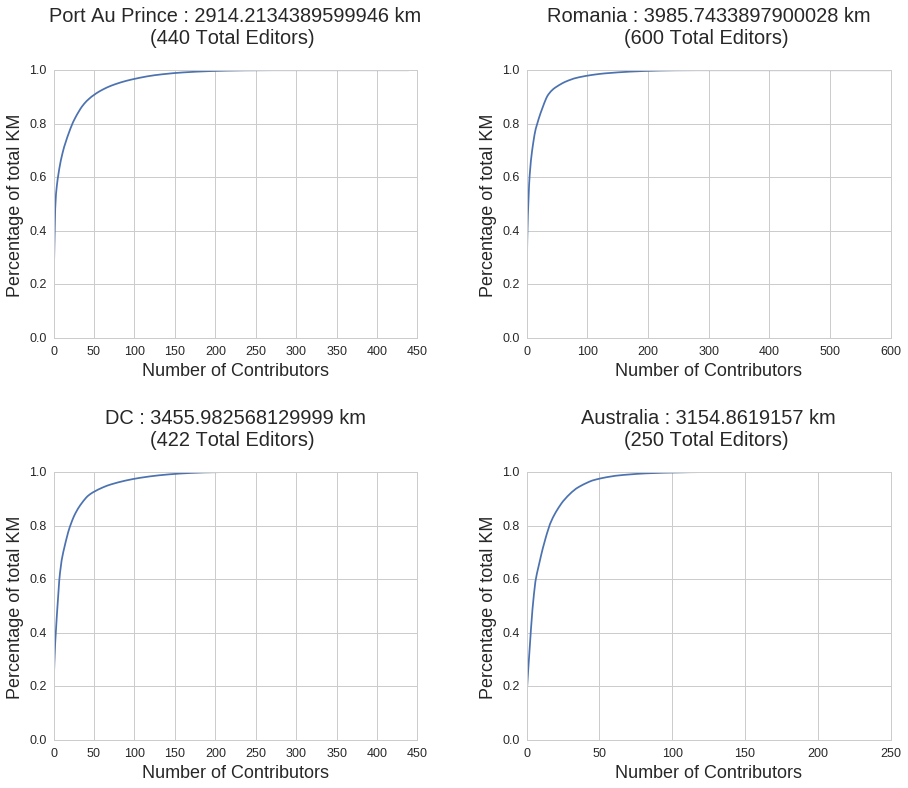

In [45]:
# Plot 4 Histograms

sns.set(font_scale=1.25)
sns.despine()
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,12), facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=0.3, hspace=0.5)
for idx, ax in enumerate(axs.ravel()):
    kms = []
    for uid, user in data[idx].items():
        kms.append(sum(user.tiles[quads[idx]].km))
        
    y = sorted(kms, reverse=True)
    total_km = sum(y)
    y_norm = np.cumsum([(x/total_km) for x in y])
    
    x = range(len(y))
#     x_norm = [i/len(x) for i in x]
    
    ax.plot(x, y_norm)
    ax.set_title("%s : %s km\n(%s Total Editors) \n"%(names[idx], total_km, len(data[idx])), fontsize=20)
    ax.set_ylabel("Percentage of total KM", fontsize=18)
    ax.set_xlabel("Number of Contributors", fontsize=18)
    ax.set_ylim([0,1])
#     ax.set_xlim([0,1])

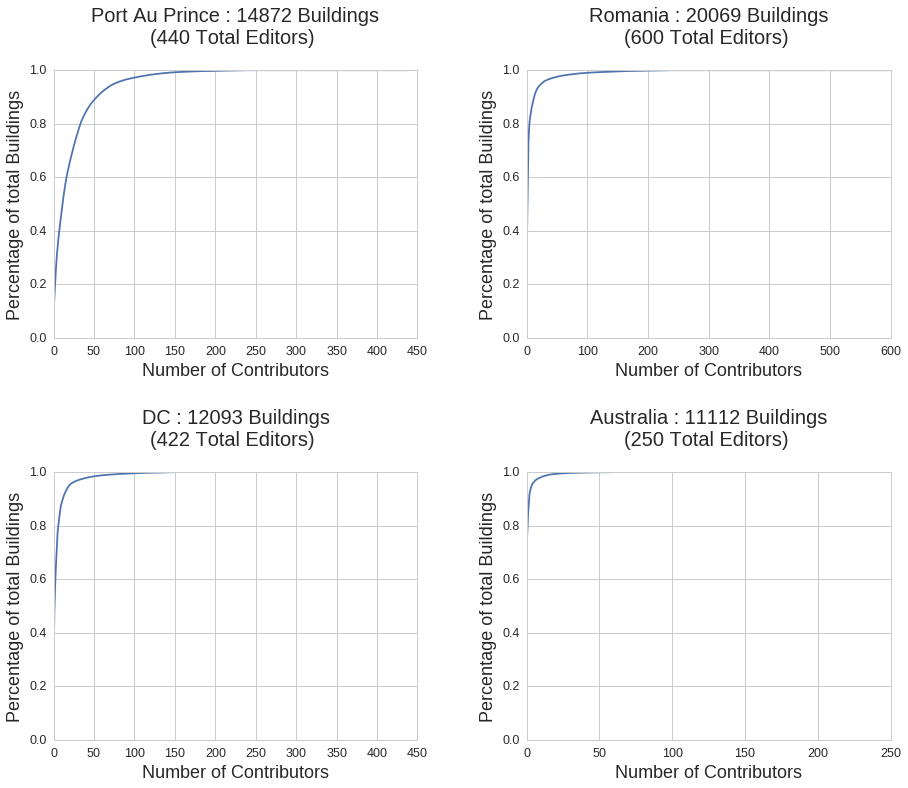

In [42]:
# Plot 4 Histograms

sns.set(font_scale=1.25)
sns.despine()
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,12), facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=0.3, hspace=0.5)
for idx, ax in enumerate(axs.ravel()):
    b = []
    for uid, user in data[idx].items():
        b.append(sum(user.tiles[quads[idx]].b))
        
    y = sorted(b, reverse=True)
    total_b = sum(y)
    y_norm = np.cumsum([(x/total_b) for x in y])
    
    x = range(len(y))
#     x_norm = [i/len(x) for i in x]
    
    ax.plot(x, y_norm)
    ax.set_title("%s : %s Buildings\n(%s Total Editors) \n"%(names[idx], total_b, len(data[idx])), fontsize=20)
    ax.set_ylabel("Percentage of total Buildings", fontsize=18)
    ax.set_xlabel("Number of Contributors", fontsize=18)
    ax.set_ylim([0,1])
#     ax.set_xlim([0,1])

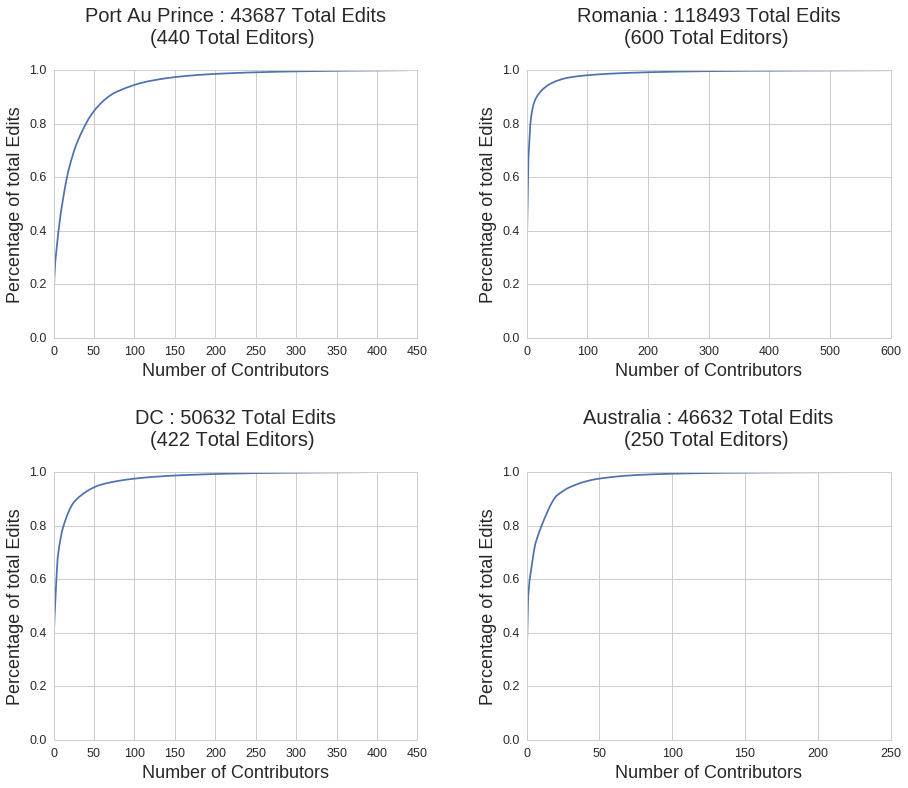

In [46]:
# Plot 4 Histograms

sns.set(font_scale=1.25)
sns.despine()
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,12), facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=0.3, hspace=0.5)
for idx, ax in enumerate(axs.ravel()):
    edits = []
    for uid, user in data[idx].items():
        edits.append(sum(user.tiles[quads[idx]].e))
        
    y = sorted(edits, reverse=True)
    total_edits = sum(y)
    y_norm = np.cumsum([(x/total_edits) for x in y])
    
    x = range(len(y))
#     x_norm = [i/len(x) for i in x]
    
    ax.plot(x, y_norm)
    ax.set_title("%s : %s Total Edits\n(%s Total Editors) \n"%(names[idx], total_edits, len(data[idx])), fontsize=20)
    ax.set_ylabel("Percentage of total Edits", fontsize=18)
    ax.set_xlabel("Number of Contributors", fontsize=18)
    ax.set_ylim([0,1])
#     ax.set_xlim([0,1])

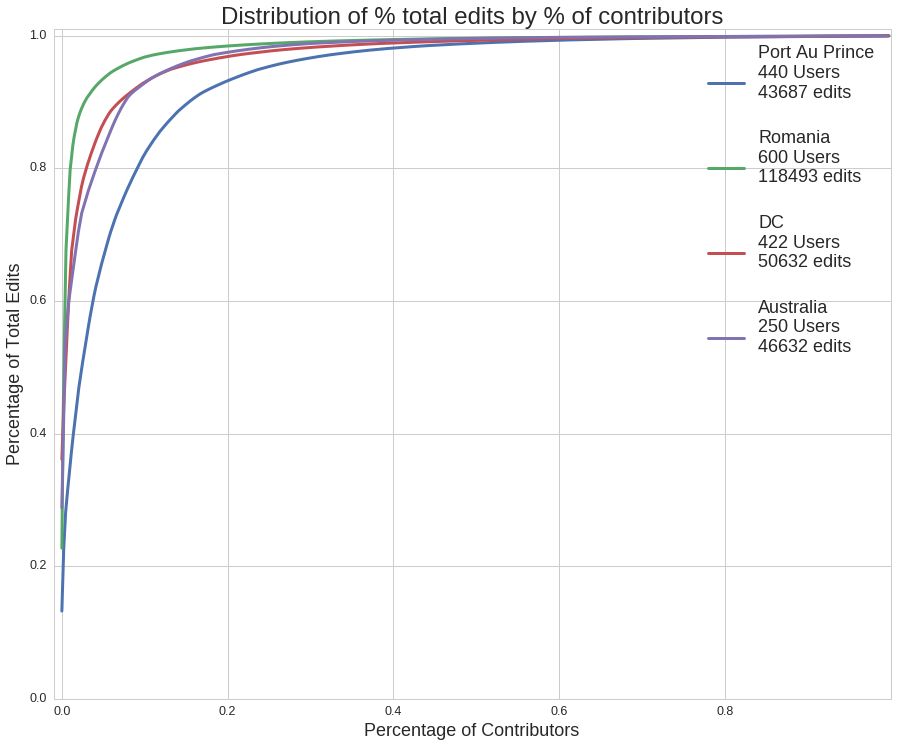

In [103]:
sns.set(font_scale=1.25)
sns.despine()
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,12), facecolor='w', edgecolor='k')
for idx in range(4):
    edits = []
    for uid, user in data[idx].items():
        edits.append(sum(user.tiles[quads[idx]].e))
        
    y = sorted(edits, reverse=True)
    total_edits = sum(y)
    y_norm = np.cumsum([(x/total_edits) for x in y])
    
    x = range(len(y))
    x_norm = [i/len(x) for i in x]
    
    ax.plot(x_norm, y_norm, label="%s\n%s Users\n%s edits\n"%(names[idx], len(y), int(total_edits)), linewidth=3)
    ax.set_title("Distribution of % total edits by % of contributors", fontsize=24)
    ax.set_ylabel("Percentage of Total Edits", fontsize=18)
    ax.set_xlabel("Percentage of Contributors", fontsize=18)
    ax.set_ylim([0,1.01])
    ax.set_xlim([-0.01,1])
    plt.legend(loc='best', fontsize=18)

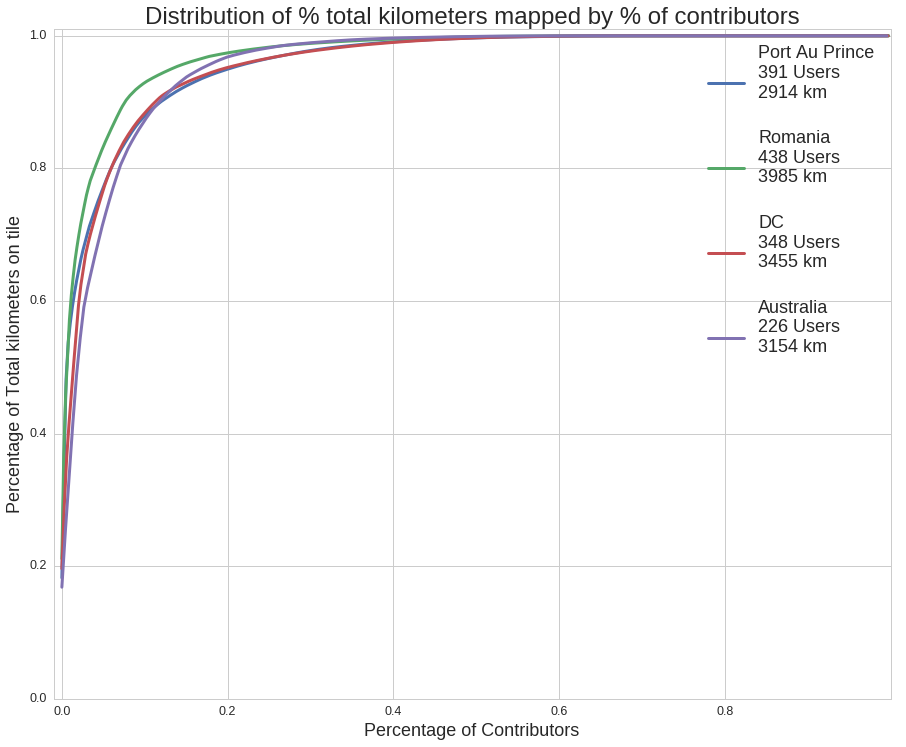

In [99]:
experience_threshold = 0
sns.set(font_scale=1.25)
sns.despine()
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,12), facecolor='w', edgecolor='k')
for idx in range(4):
    kms = []
    for uid, user in data[idx].items():
        if user.km > experience_threshold:
            kms.append(sum(user.tiles[quads[idx]].km))
        
    y = sorted(kms, reverse=True)
    total_km = sum(y)
    y_norm = np.cumsum([(x/total_km) for x in y])
    
    x = range(len(y))
    x_norm = [i/len(x) for i in x]
    
    ax.plot(x_norm, y_norm, label="%s\n%s Users\n%s km\n"%(names[idx], len(y), int(total_km)), linewidth=3)
#     ax.set_title("Who's Doing the Mapping? (Users with > %s km experience)"%(experience_threshold))
    ax.set_title("Distribution of % total kilometers mapped by % of contributors", fontsize=24)
    ax.set_ylabel("Percentage of Total kilometers on tile", fontsize=18)
    ax.set_xlabel("Percentage of Contributors", fontsize=18)
    ax.set_ylim([0,1.01])
    ax.set_xlim([-0.01,1])
    plt.legend(loc='best', fontsize=18)

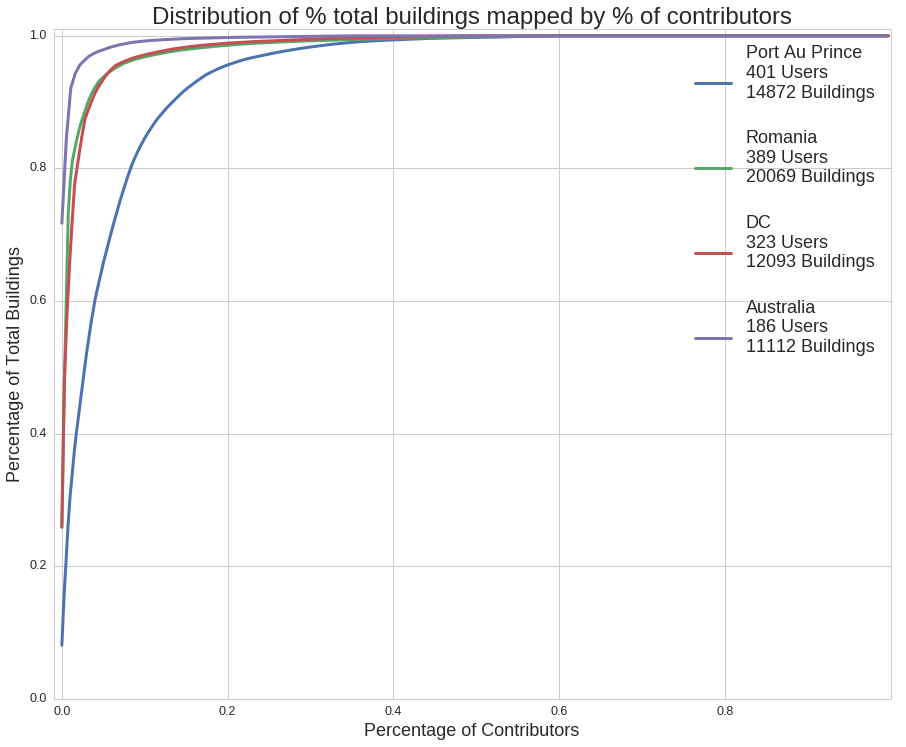

In [98]:
experience_threshold = 0
sns.set(font_scale=1.25)
sns.despine()
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,12), facecolor='w', edgecolor='k')
for idx in range(4):
    b = []
    for uid, user in data[idx].items():
        if user.b > experience_threshold:
            b.append(sum(user.tiles[quads[idx]].b))
        
    y = sorted(b, reverse=True)
    total_b = sum(y)
    y_norm = np.cumsum([(x/total_b) for x in y])
    
    x = range(len(y))
    x_norm = [i/len(x) for i in x]
    
    ax.plot(x_norm, y_norm, label="%s\n%s Users\n%s Buildings\n"%(names[idx], len(y), total_b), linewidth=3)
    ax.set_title("Distribution of % total buildings mapped by % of contributors", fontsize=24)
    ax.set_ylabel("Percentage of Total Buildings", fontsize=18)
    ax.set_xlabel("Percentage of Contributors", fontsize=18)
    ax.set_ylim([0,1.01])
    ax.set_xlim([-0.01,1])
    plt.legend(loc='best', fontsize=18)